In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyximport

import matplotlib.collections as mcoll

pyximport.install(setup_args={'include_dirs': np.get_include()},reload_support=True)
from RigidWallOverdampedLangevin3D_cython import RigidWallOverdampedLangevin3D 

from mpl_toolkits import mplot3d
from scipy.signal import correlate
from scipy.optimize import curve_fit

import matplotlib.gridspec as gridspec
from mpl_toolkits import mplot3d
from scipy.signal import correlate

import time

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 140

mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 0.1
mpl.rcParams["figure.dpi"] = 130
from matplotlib import rc
rc('font', family='serif')
rc('text', usetex=True)
rc('xtick', labelsize=10)
rc('ytick', labelsize=10)

# Langevin 3D overdamped close rigid wall

<font color='blue'>
    We have that equation to compute : 

\begin{equation}
    x_i = x_{i-1} + ( - \Delta m g + R_{elec} + F_{correction} ) \frac{\Delta t}{\gamma (z)} + a(\gamma (z)) ~ dB_t ~ \Delta t
\end{equation}
    where:
\begin{equation}
    R_{elec} = \frac{4 k_b T}{l_d} exp( - \frac{z}{l_d})
\end{equation}
    and,
\begin{equation}
    F_{correction} = k_b T \frac{D_z'}{D_z} = k_b T \frac{42 R z^2 + 24 R^2z + 4R^2}{36 z^4 + 66Rz^3 + 30 R^2 z^2 + 4R^3 z}.
\end{equation}</font>
    
<font color='blue'>    
    $dB_t$ is a white noise like a gaussian law, with a average at zero and standard deviation at $\frac{1}{\Delta t}$. 
</font>

<font color='blue'>    
    $\gamma_x$ and $\gamma_y$ are compute with Libchaber paper formula and $\gamma_z$ with the Pade formula.
</font>


In [2]:
# tps1 = time.time()

langevin3D = RigidWallOverdampedLangevin3D(dt=1e-2, Nt=30000000, R=1.5e-6, rho=1050, x0=(0., 0., 1.5e-6))
langevin3D.trajectory()

# tps2 = time.time()

In [3]:
# print("Temps de calcul de la trajectoire : t = " + np.str(tps2 - tps1) + " s")

In [4]:
langevin3D.m/langevin3D.gamma

3.9375e-07

In [5]:
# trajectories = langevin3D.x, langevin3D.y, langevin3D.z
# np.savetxt('Numerical_Trajectory_rigid_wall_langevin3D.txt', trajectories)

## 1. Trajectory

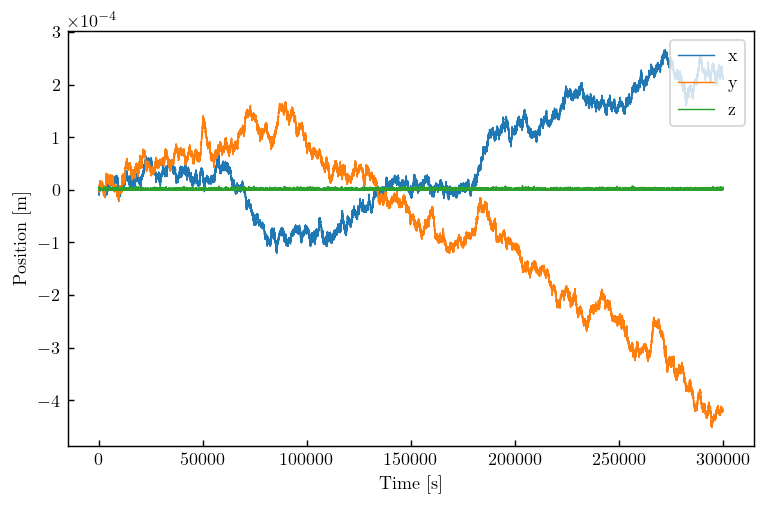

In [6]:
langevin3D.plotTrajectory()

## 2. Mean square displacement

In [7]:
MSDx = langevin3D.MSD1D("x", output=True)
MSDy = langevin3D.MSD1D("y", output=True)
MSDz = langevin3D.MSD1D("z", output=True)

<ipython-input-7-18bc2dd859a9>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  MSDx = langevin3D.MSD1D("x", output=True)
<ipython-input-7-18bc2dd859a9>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; 

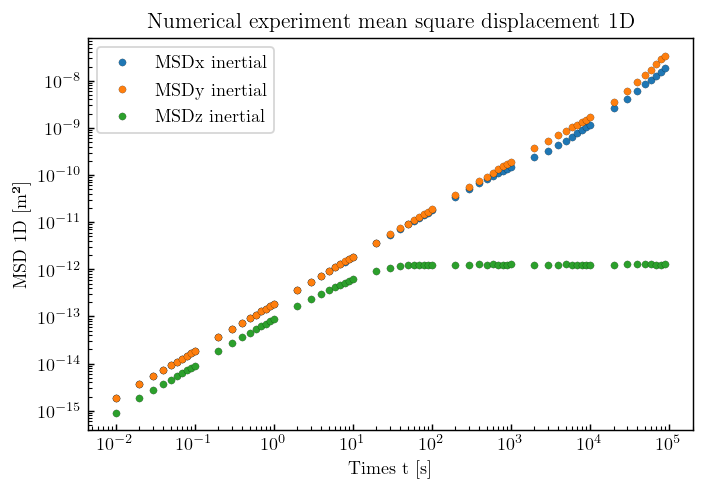

In [8]:
fig1 = plt.figure()
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD],
    MSDx,
            "o", markersize=4,
    label="MSDx inertial",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDy,
            "o", markersize=4,
    label="MSDy inertial",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDz,
    "o", markersize=4,
    label="MSDz inertial",
)
plt.xlabel("Times t [s]")
plt.ylabel("MSD 1D [m²]")
plt.title("Numerical experiment mean square displacement 1D")
plt.legend()
plt.show()

## 3. Probability density function of z

<font color='blue'>    
    We compute the PDF of z trajectory and verify with the theory like :
</font>
<font color='blue'>  
    \begin{equation}
        P(z) = exp(- 4 ~ exp(- \frac{z}{l_d} ) - \frac{z}{l_b} ),
    \end{equation}
</font>
<font color='blue'>  
    with $l_b = \frac{k_b T}{\Delta m g}$ the Boltzmann lenght and $l_d$ the Debay lenght.
</font>

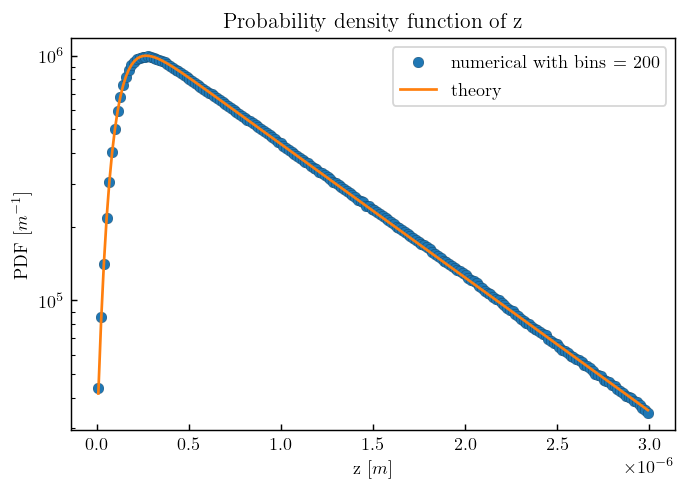

In [9]:
axis = "z"
bins = 200
hist, bin_edges = np.histogram(langevin3D.z[langevin3D.z < 3e-6], bins=bins, density=True)
binsPosition = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf = hist * 1/np.trapz(hist,binsPosition)

pdf_theo_brut = np.exp( -(4) * np.exp(- binsPosition/langevin3D.lD) - binsPosition/langevin3D.lB)
pdf_theo = pdf_theo_brut * 1/np.trapz(pdf_theo_brut,binsPosition) # normalised

plt.semilogy(binsPosition,pdf, "o", label="numerical with bins = " + str(bins))
plt.plot(binsPosition, pdf_theo, "-", label="theory")

plt.title("Probability density function of " + axis)
plt.xlabel(axis + " $[m]$")
plt.ylabel("PDF $[m^{-1}]$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.legend()
# plt.savefig("pdfz.pdf")


## 4. MSD in theory

## 4.1 Calculation of the MSDz plateau:

### 4.1.1) Calculation of P($\Delta$z)

<font color='blue'>    
    To compute the PDF of $\Delta z$ when $D_i$ is independant of $z$, we need to calculate :
    \begin{equation}
        P(\Delta z) = \int_{0}^{+\infty} P(z)~P(z+\Delta z)  \, \mathrm{d}z
    \end{equation}
    C'est la PDF($\Delta z$) au temps long avec un mur (je crois à verif).
</font>

In [10]:
def P_z(z, A, B, lD, lB):
    # PDF(z)
    if type(z)!=np.ndarray:
        if z<0:
            return 0
        return A * np.exp( -(B) * np.exp(- z/lD) - z/lB)
    
    P = A * np.exp( -(B) * np.exp(- z/lD) - z/lB)
    P[z<0] = 0
    
    return P
    
    
def Pz_PDeltaz(z, deltaz, A, B, lD, lB):
    #P(z)*P(z+Deltaz)
    PP = P_z(z, A, B, lD, lB) * P_z(z+deltaz, A, B, lD, lB) 
    
    return PP
    
    
def _P_Deltaz_longTime(z, deltaz, A, B, lD, lB):
    # integrate of P(z)*P(z+Deltaz) on z
    PPP = np.trapz(Pz_PDeltaz(z, deltaz, A, B, lD, lB), z)
    
    return PPP
  
    
def P_Deltaz_longTime(deltaz, B, lD, lB):
    A = 1
    z = np.linspace(0, 1e-5, 1000)
    PPPP = np.zeros(len(deltaz))
    for i in range(len(deltaz)):
        PPPP[i] = _P_Deltaz_longTime(z, deltaz[i], A, B, lD, lB)
    A = 1/np.trapz(PPPP, deltaz)
    
    return PPPP*A
    
    
dz = np.linspace(-1e-5, 1e-5, 10000)
P_dz = P_Deltaz_longTime(dz, 4, langevin3D.lD, langevin3D.lB)
np.trapz(P_dz, dz) # verification than P_z integral is 1

0.9999999999999999

Text(0.5, 1.0, 'P($\\Delta z$)')

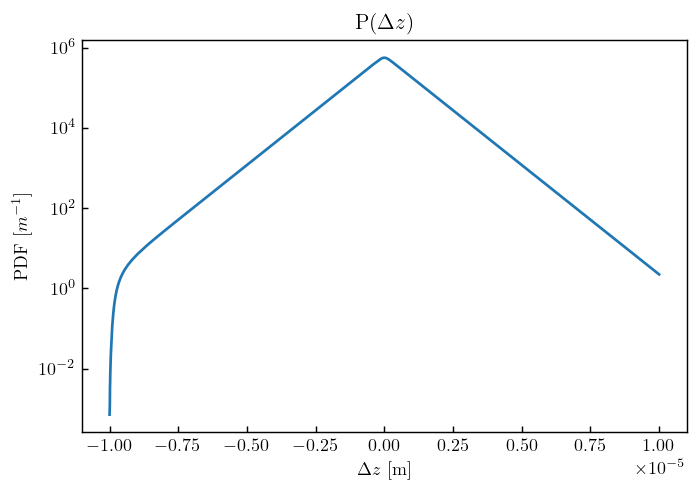

In [11]:
plt.semilogy(dz,P_dz)
plt.xlabel("$\\Delta z$ [m]")
plt.ylabel("PDF [$m^{-1}$]")
plt.title("P($\\Delta z$)")
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

### 4.1.2) Calculation of <$\Delta$z$^2$>

<font color='blue'>    
    With the PDF of $\Delta z$, we can cumpute the average of $\Delta z^2$ that is the plateau of MSDz :
    \begin{equation}
        <\Delta z^2> = \int_{0}^{+\infty} (\Delta z)^2~P(\Delta z)  \, \mathrm{d}(\Delta z)
    \end{equation}
</font>

In [12]:
def mean_Deltaz_square(Deltaz, P_Deltaz):
    f = Deltaz**2 * P_Deltaz
    mean = np.trapz(f, Deltaz)
    
    return mean
 
Mean_dz2 = mean_Deltaz_square(dz, P_dz)
print("<dz²> = {:.2e} m²".format(Mean_dz2))

<dz²> = 1.28e-12 m²


### 4.2. Mesure of average of diffusion coeficient

<font color='blue'>    
    We also can compute the avarage of the diffusion coefficient with the thoritical PDF of z :
    \begin{equation}
        <D_x> = <D_y> = \int_{0}^{+\infty} D_{x,y}(z)~P(z)  \, \mathrm{d}z,
    \end{equation}
     and,
     \begin{equation}
        <D_z> = \int_{0}^{+\infty} D_{z}(z)~P(z)  \, \mathrm{d}z,
    \end{equation}
    with,
    \begin{equation}
        D_{x,y,z}(z) = \frac{k_b T }{\gamma_{x,y,z}(z)}
    \end{equation}
</font>

In [13]:
# ----- On Z --------- !
# Diffusion coef
Dz = (langevin3D.kb*langevin3D.T) / (langevin3D._gamma_z(binsPosition))
# function to integrate
f_theo = Dz * pdf_theo
# Theoritical diffusion coef
mean_D_theo = np.trapz(f_theo,binsPosition)
print("<Dz>_theo/D_0 = {:.2f}".format(mean_D_theo/(langevin3D.kb * langevin3D.T / langevin3D.gamma)))

# -------- On X ----------- !
Dx = (langevin3D.kb*langevin3D.T) / (langevin3D._gamma_xy(binsPosition))
fx_theo = Dx * pdf_theo
mean_Dx_theo = np.trapz(fx_theo,binsPosition)
print("<Dx>_theo/D_0 = {:.10f}".format(mean_Dx_theo/(langevin3D.kb * langevin3D.T / langevin3D.gamma)))

<Dz>_theo/D_0 = 0.30
<Dx>_theo/D_0 = 0.6174104154


### 4.3. Fit of MSDz

<font color='blue'>    
    The fit of MSDz give the numerical experiemental value of the plateau, that we can plot.
</font>

In [14]:
#Fit de la MSDz
x = langevin3D.t[langevin3D.list_dt_MSD]
y = MSDz

def func(x, a, b):
    return a*(1-np.exp(b*x))

popt, pcov = curve_fit(func, x, y, p0=(4e-13, -1e-1))

a=popt[0]
b=popt[1]
MSDz_fit = func(x, a, b)

<ipython-input-14-72f8a71b0514>:6: RuntimeWarning: overflow encountered in exp
  return a*(1-np.exp(b*x))


### 4.4. Plot of MSDs

<font color='blue'>    
    Finaly, we plot MSDx, and MSDy and the theoritical line of $MSD_{x,y}~ = ~2<D_{x,y}(z)>t$.
</font>

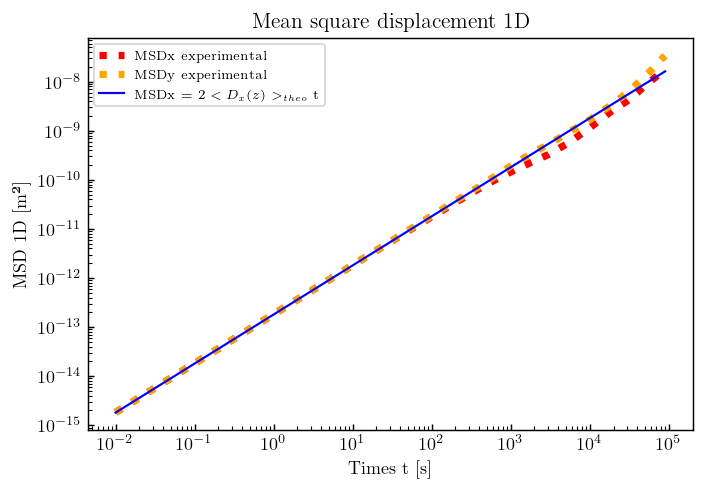

In [15]:
## plot on x and y
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD],
    MSDx,
    linestyle=":",
    color="red",
    linewidth=4,
    label="MSDx experimental",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDy,
    linestyle=":",
    color="orange",
    linewidth=4,
    label="MSDy experimental",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    2*mean_Dx_theo
    * langevin3D.t[langevin3D.list_dt_MSD],
    color="blue",
    linewidth=1.2,
    label="MSDx = $2<D_x(z)>_{theo}$ t",
)
plt.xlabel("Times t [s]")
plt.ylabel("MSD 1D [m²]")
plt.title("Mean square displacement 1D")
plt.legend(fontsize="x-small")
plt.show()

<font color='blue'>    
    And we plot experimental MSDz, its fit, the theoritical plateau and the theoritical line of $MSD_{z}~ = ~2<D_{z}(z)>t$ true for low times.
</font>

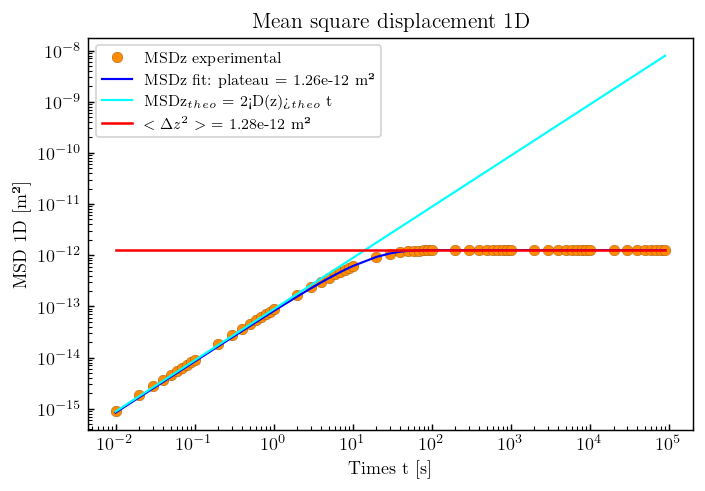

In [16]:
## plot on z
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDz,
    "o",
    #linestyle=":",
    color="darkorange",
    linewidth=5,
    label="MSDz experimental",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDz_fit,
    linestyle="-",
    color="blue",
    linewidth=1.2,
    label="MSDz fit: plateau = {:.2e} m²".format(a)
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    2*mean_D_theo
    * langevin3D.t[langevin3D.list_dt_MSD],
    color="cyan",
    linewidth=1.2,
    label="MSDz$_{theo}$ = 2<D(z)>$_{theo}$ t",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    Mean_dz2 * np.ones(len(langevin3D.list_dt_MSD)),
    color="red",
    linewidth=1.4,
    label="$<\\Delta z ^2>$ = {:.2e} m²".format(Mean_dz2),
)
plt.xlabel("Times t [s]")
plt.ylabel("MSD 1D [m²]")
plt.title("Mean square displacement 1D")
plt.legend(fontsize="small")
plt.show()

<font color='blue'>    
    These results could be improved with a longer trajectory.
</font>

### --> Ceci est un plot pour le rapport (joli) :)

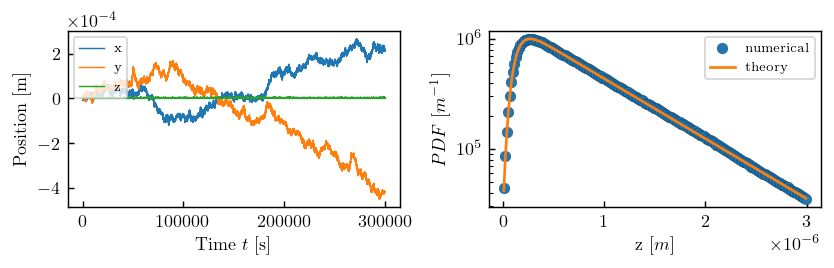

In [17]:
def cm2Inch(cm):
    inch = cm / 2.54
    return inch

w = cm2Inch(21 - 5)
h = cm2Inch((21 - 5)/1.618)
fig = plt.figure(constrained_layout=True, figsize=(w,h/2))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

###################################################
fig.add_subplot(spec[0, 0])

plt.plot(langevin3D.t, langevin3D.x, linewidth=0.8, label="x")
plt.plot(langevin3D.t, langevin3D.y, linewidth=0.8, label="y")
plt.plot(langevin3D.t, langevin3D.z, linewidth=0.8, label="z")
plt.xlabel("Time $t$ [s]")
plt.ylabel("Position [m]")
plt.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))
plt.legend(loc="upper left", fontsize="x-small")

###################################################
fig.add_subplot(spec[0, 1])


axis = "z"
bins = 200
hist, bin_edges = np.histogram(langevin3D.z[langevin3D.z < 3e-6], bins=bins, density=True)
binsPosition = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf_z = hist * 1/np.trapz(hist,binsPosition)

pdf_theo_brut = np.exp( -(4) * np.exp(- binsPosition/langevin3D.lD) - binsPosition/langevin3D.lB)
pdf_theo = pdf_theo_brut * 1/np.trapz(pdf_theo_brut,binsPosition) # normalised

plt.semilogy(binsPosition,pdf_z, "o", label="numerical")
plt.plot(binsPosition, pdf_theo, "-", label="theory")

plt.xlabel(axis + " $[m]$")
plt.ylabel("$PDF$ $[m^{-1}]$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.legend(fontsize="x-small")

# plt.savefig("RigidWall_Overdamped1.svg")

## PDF Delta z temps court et long 

Comme $D(z)$ dépend de la position $z$, alors la proba de déplacement $P(\Delta z)$ dépend de la distribution de $D_x(z)$, $D_y(z)$ et $D_z(z)$.

\begin{equation}
    P(\Delta x_i, \Delta t) = \frac{1}{N} \int_{0}^{+\infty}  P(D_i)~exp \left ( -\frac{\Delta z^2}{4D_i \Delta t} \right )  \, \mathrm{d}D_i,
\end{equation}

où chaque point de l'espace a son propre $D_i$.

In [18]:
def pdf(data, bins = 50, density = True):
    #PDF(data)
    
    pdf, bins_edge = np.histogram(data, bins = bins, density = density)
    bins_center = (bins_edge[0:-1] + bins_edge[1:]) / 2
    
    return pdf, bins_center 

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

##################################################
# Calcul théo de la PDF(Delta xi, Delta t) avec le mur -> D(z) non constant

def pdf_Di(axis="z"):
    """
    Calcul la PDF(Di)
    """
    z = np.linspace(1e-10, 10e-6, 1000)
    
    if axis == "z":
        Di = langevin3D.kb*langevin3D.T/langevin3D._gamma_z(z)
    
    else:
        Di = langevin3D.kb*langevin3D.T/langevin3D._gamma_xy(z)
#         z = np.linspace(-10e-6, 10e-6, 1000)
        
    pdf_xi = P_z(z, 1, 4, langevin3D.lD, langevin3D.lB)
    
    return Di, Di*pdf_xi

def f_to_integrate(dz,n_dt, axis="z"):
    """
    Calcul de la fonction à intégrer pour 1 dt donnée
    """
    Di, PDi = pdf_Di(axis)
    f = PDi * 1/np.sqrt(4*np.pi*Di*n_dt*langevin3D.dt) * np.exp(-dz**2/(4*Di*n_dt*langevin3D.dt))

    return f, Di

def _pdf_DeltaXi_Delta_t(dz, n_dt, axis="z"):
    """
    Calcul de l'intégrale pour 1 Di.
    """
    f, Di = f_to_integrate(dz, n_dt, axis=axis)
    non_normalised = np.trapz(f, Di)
        
    return non_normalised

def pdf_DeltaXi_Delta_t(dz, n_dt, axis="z"):
    """
    Calcul de l'intégrale pour une liste Di.
    """
    A = 1
    Di = f_to_integrate(dz,n_dt, axis=axis)[1] #on récupère Di
    result = np.zeros(len(dz))
    
    for i in range(len(dz)):
        result[i] = _pdf_DeltaXi_Delta_t(dz[i], n_dt, axis=axis)
    
    A = 1/np.trapz(result, dz)
    
    return A*result


Text(0.5, 0, '$\\Delta x/\\sigma$ ')

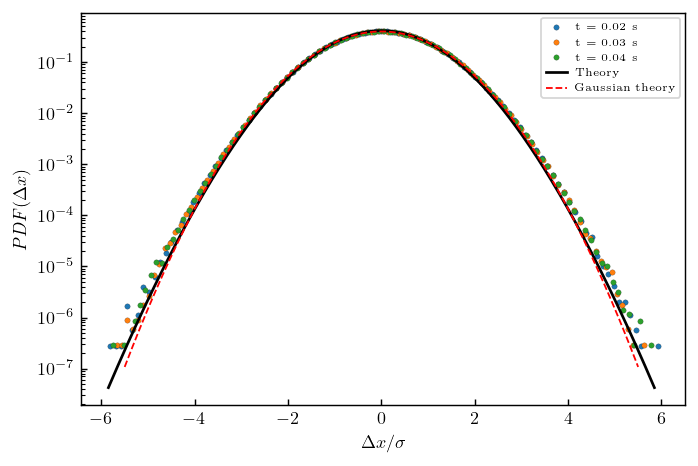

In [19]:
## PDF Dx (all time)

Di = pdf_Di(axis="x")[0]
dx = np.linspace(-5e-7, 5e-7, len(Di))

I = [2, 3, 4]

for i in I:
    
    Dezs = (langevin3D.x[0:-i] - langevin3D.x[i:])
    std = np.std(Dezs)
    Dezs = Dezs / std #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 100)
    plt.semilogy(bins_center, hist, ".",label = " t = {:.2f} s".format(langevin3D.t[i]))
    if i == I[-1]:
        PDF_X =  pdf_DeltaXi_Delta_t(dx,i, axis="x")
        plt.semilogy(dx/std, PDF_X/np.trapz(PDF_X, dx/std), "k", label="Theory")
    

    
x_theo = np.linspace(-5.5, 5.5, 1000)
gaussian_theo = gauss_function(x_theo, 1, 0, 1)
gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, x_theo)
    
plt.semilogy(x_theo, gaussian_theo, "--", color="red",linewidth=1., label="Gaussian theory")
    
plt.legend(fontsize="xx-small")
plt.ylabel("$PDF(\Delta x)$")
plt.xlabel("$\Delta x/\sigma$ ") #($\mu m$)

Text(0.5, 0, '$\\Delta z/\\sigma$ ')

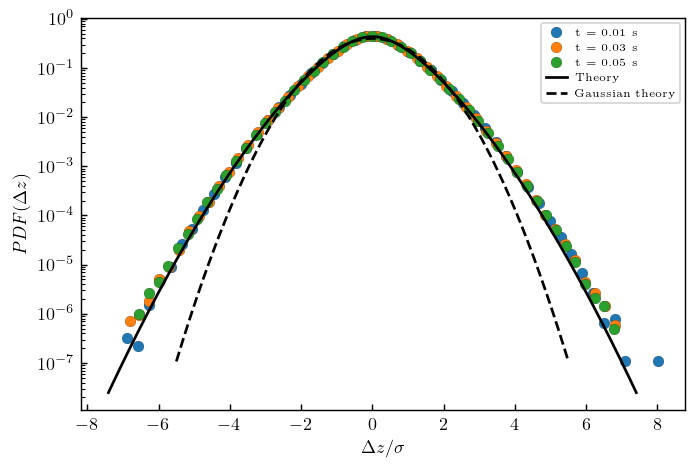

In [20]:
## PDF Dz SHORT TIME
I = [1,3,5]

Di = pdf_Di(axis="z")[0]
dz = np.linspace(-5e-7, 5e-7, len(Di))

for i in I:
    
    Dezs = (langevin3D.z[0:-i] - langevin3D.z[i:])
    std = np.std(Dezs)
    Dezs = Dezs / std #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 50)
    plt.semilogy(bins_center, hist, "o",label = " t = {:.2f} s".format(langevin3D.t[i]))
    if i == 5:
        PDF =  pdf_DeltaXi_Delta_t(dz,i)
        plt.semilogy(dz/std,PDF/np.trapz(PDF,dz/std), "k", label="Theory")
    

    
z_theo = np.arange(-5.5,5.5, 0.01)
gaussian_theo = gauss_function(z_theo, 1, 0, 1)
gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, z_theo)
    
plt.semilogy(z_theo, gaussian_theo, "--", color="black", label="Gaussian theory")
    
plt.legend(fontsize="xx-small")
plt.ylabel("$PDF(\Delta z)$")
plt.xlabel("$\Delta z/\sigma$ ")

Text(0.5, 0, '$\\Delta z ~ [m]$ ')

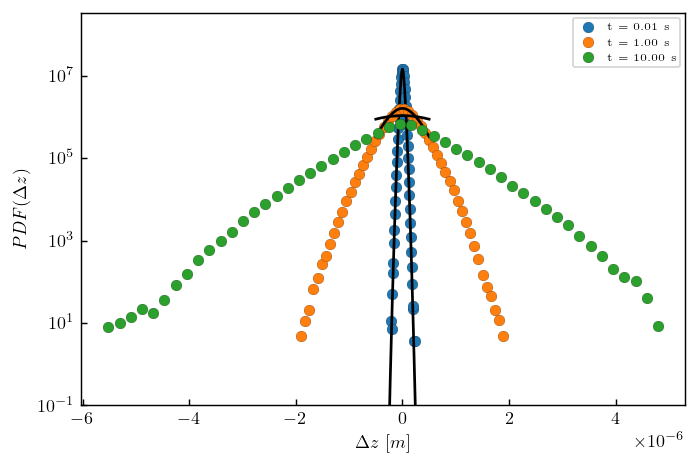

In [21]:
## PDF Dz SHORT TIME non normalised
I = [1,100,1000]

for i in I:
    
    Dezs = (langevin3D.z[0:-i] - langevin3D.z[i:])
    std = np.std(Dezs)
    Dezs = Dezs #/ std #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 50)
    plt.semilogy(bins_center, hist, "o",label = " t = {:.2f} s".format(langevin3D.t[i]))
    dz = np.linspace(-5e-7, 5e-7, len(Di))
    PDF =  pdf_DeltaXi_Delta_t(dz,i)
    plt.semilogy(dz,PDF/np.trapz(PDF,dz), "k")
    

    
z_theo = np.arange(-200.5,200.5, 0.01)
gaussian_theo = gauss_function(z_theo, 1, 0, 1)
gaussian_theo = gaussian_theo #* 1/np.trapz(gaussian_theo, z_theo)
    
# plt.semilogy(z_theo, gaussian_theo, label="Gaussian theory")
plt.ylim([1e-1,None])
plt.legend(fontsize="xx-small")
plt.ylabel("$PDF(\Delta z)$")
plt.xlabel("$\Delta z ~ [m]$ ") #($\mu m$)


Text(0.5, 0, '$\\Delta z/\\sigma$ ')

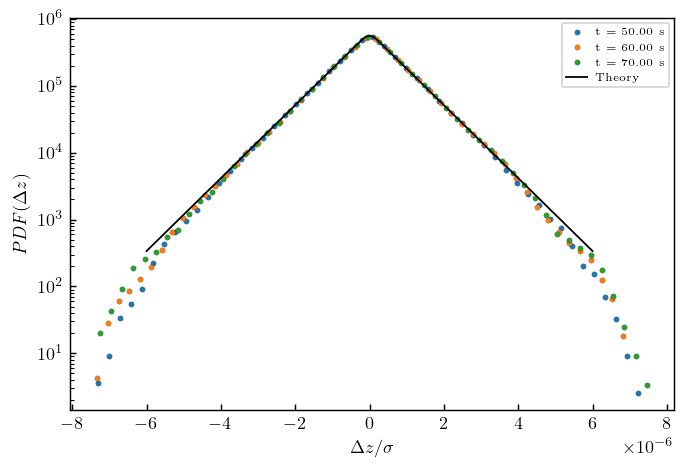

In [22]:
## PDF Dz LONG TIME
I = [5000, 6000, 7000]

Di = pdf_Di(axis="z")[0]
dz = np.linspace(-6e-6, 6e-6, len(Di))

for i in I:
    
    Dezs = (langevin3D.z[0:-i] - langevin3D.z[i:])
    std = 1#np.std(Dezs)
    Dezs = Dezs / std #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 50)
    plt.semilogy(bins_center, hist, ".",label = " t = {:.2f} s".format(langevin3D.t[i]))

    if i == I[-1]:
        PDF_theo_long = P_Deltaz_longTime(dz, 4, langevin3D.lD, langevin3D.lB)
        plt.semilogy(dz/std, 
                     PDF_theo_long / np.trapz(PDF_theo_long, dz/std), 
                     color="black", linewidth=1., label="Theory")
    

    
# z_theo = np.arange(-5.5,5.5, 0.01)
# gaussian_theo = gauss_function(z_theo, 1, 0, 1)
# gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, z_theo)
    
# plt.semilogy(z_theo, gaussian_theo, "--", color="red", linewidth=1., label="Gaussian theory")
    
plt.legend(fontsize="xx-small")
plt.ylabel("$PDF(\Delta z)$")
plt.xlabel("$\Delta z/\sigma$ ") #($\mu m$)


## Plot joli pour rapport

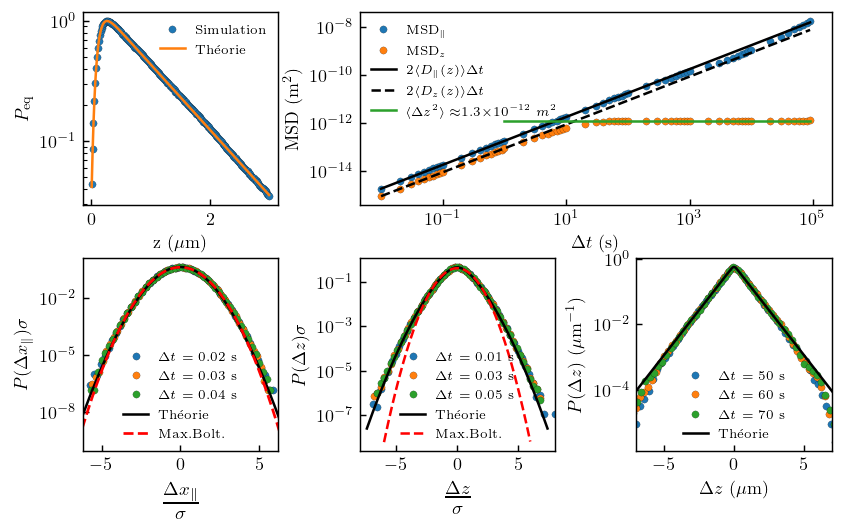

In [23]:
fig = plt.figure(figsize=(w, h), constrained_layout=False)
gs = fig.add_gridspec(2,3)

##### PDF_z

fig.add_subplot(gs[0, 0])


axis = "z"
bins = 200
hist, bin_edges = np.histogram(langevin3D.z[langevin3D.z < 3e-6], bins=bins, density=True)
binsPosition = ((bin_edges[:-1] + bin_edges[1:]) / 2)
pdf_z = hist * 1/np.trapz(hist,binsPosition*1e6)

pdf_theo_brut = np.exp( -(4) * np.exp(- binsPosition/langevin3D.lD) - binsPosition/langevin3D.lB)
pdf_theo = pdf_theo_brut * 1/np.trapz(pdf_theo_brut,binsPosition*1e6) # normalised

plt.semilogy(binsPosition*1e6,pdf_z, "o", markersize=4, label=r"Simulation")
plt.plot(binsPosition*1e6, pdf_theo, "-", linewidth=1.4, label=r"Théorie")

plt.xlabel(axis + r" ($\mu$m)", fontsize=10)
plt.ylabel(r"$P_\mathrm{eq}$", fontsize=10)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.legend(fontsize="x-small", frameon=False)


##### MSD

fig.add_subplot(gs[0,1:])

plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD],
    MSDx,
    "o", markersize=4,
    label=r"MSD$_{\|}$",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDz,
    "o", markersize=4,
    label=r"MSD$_{z}$",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    2*mean_Dx_theo
    * langevin3D.t[langevin3D.list_dt_MSD],
    color="black",
    linewidth=1.4,
    label=r"$2 \langle D_{\|}(z) \rangle \Delta t$",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    2*mean_D_theo
    * langevin3D.t[langevin3D.list_dt_MSD],
    "--",
    color="black",
    linewidth=1.4,
    label=r"$2 \langle D_{z}(z) \rangle  \Delta t$",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD[18:]] ,
    Mean_dz2 * np.ones(len(langevin3D.list_dt_MSD[18:])),
    "-",
    linewidth=1.4,
    label=r"$\langle \Delta z^2 \rangle \approx $" + str(round(Mean_dz2, 13))[:3]+ r"$\times 10^{"+ str(round(Mean_dz2, 13))[4:7] +"}$ $m^2$",
)

plt.xlabel(r"$\Delta t$ (s)", fontsize=10)
plt.ylabel(r"MSD (m$^2$)", fontsize=10)
plt.legend(fontsize="x-small", frameon=False)


####### SHORT TIME PDF X ###############################################################
def pdf(data, bins = 50, density = True):
    #PDF(data)
    
    pdf, bins_edge = np.histogram(data, bins = bins, density = density)
    bins_center = (bins_edge[0:-1] + bins_edge[1:]) / 2
    
    return pdf, bins_center 

fig.add_subplot(gs[1,0])

Di = pdf_Di(axis="x")[0]
dx = np.linspace(-5.5e-7, 5.5e-7, len(Di))

I = [2, 3, 4]

for i in I:
    
    Dezs = (langevin3D.x[0:-i] - langevin3D.x[i:])
    std = np.std(Dezs)
    Dezs = Dezs / std #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 50)
    plt.semilogy(bins_center, hist, "o", markersize=4, label = r"$\Delta t$ = {:.2f} s".format(langevin3D.t[i]))
    if i == I[-1]:
        PDF_X =  pdf_DeltaXi_Delta_t(dx,i, axis="x")
        plt.semilogy(dx/std, PDF_X/np.trapz(PDF_X, dx/std), "k-", linewidth=1.4, label="Théorie")
    

    
x_theo = np.linspace(-6.5, 6.5, 1000)
gaussian_theo = gauss_function(x_theo, 1, 0, 1)
gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, x_theo)
    
plt.semilogy(x_theo, gaussian_theo, "--", color="red", linewidth=1.5, label="Max.Bolt.")
    
plt.xlim([-6.2, 6.2])
plt.legend(fontsize="x-small", frameon=False)
plt.ylabel(r"$ P(\Delta x_{\|})\sigma$", fontsize=10)
plt.xlabel(r"$\frac{\Delta x_{\|}}{\sigma} $ ", fontsize=15) #($\mu m$)


####### SHORT TIME PDF Z ###############################################################

fig.add_subplot(gs[1,1])

#------> construction de la theorie temps court
Di = pdf_Di(axis="z")[0]
dz = np.linspace(-5e-7, 5e-7, len(Di))

I = [1, 3, 5]

for i in I:
    
    Dezs = (langevin3D.z[0:-i] - langevin3D.z[i:])
    std = np.std(Dezs)
    Dezs = Dezs / std #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 50)
    plt.semilogy(bins_center, hist, "o", markersize=4, label = r"$\Delta t$ = {:.2f} s".format(langevin3D.t[i]))
    
    if i == 5:
        PDF_theo_court =  pdf_DeltaXi_Delta_t(dz,i)
        plt.semilogy(dz/std, 
                     PDF_theo_court/np.trapz(PDF_theo_court,dz/std), 
                     color="black", linewidth=1.4, label=r"Théorie")
    
z_theo = np.arange(-6, 6, 0.01)
gaussian_theo = gauss_function(z_theo, 1, 0, 1)
gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, z_theo)
    
plt.semilogy(z_theo, gaussian_theo, "--", linewidth=1.4, color="red", label="Max.Bolt.")

plt.xlim([-8, 8])
plt.legend(fontsize="x-small", frameon=False)
plt.ylabel(r"$ P(\Delta z)\sigma$", fontsize=10)
plt.xlabel(r"$\frac{\Delta z}{\sigma} $ ", fontsize=15)


###### LONG TIME PDF Z ###############################################################


fig.add_subplot(gs[1,2])

I = [5000, 6000, 7000]

Di = pdf_Di(axis="z")[0]
dz = np.linspace(-8e-6, 8e-6, len(Di))

for i in I:
    
    Dezs = (langevin3D.z[0:-i] - langevin3D.z[i:])
    std = 1
    Dezs = Dezs #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 50)
    plt.semilogy(bins_center*1e6, hist/np.trapz(hist, bins_center*1e6), "o", markersize=4, label = r"$\Delta t$ = {:.0f} s".format(langevin3D.t[i]))

    if i == I[-1]:
        PDF_theo_long = P_Deltaz_longTime(dz, 4, langevin3D.lD, langevin3D.lB)
        plt.semilogy(dz*1e6, 
                     PDF_theo_long / np.trapz(PDF_theo_long, dz*1e6), 
                     color="black", linewidth=1.4, label=r"Théorie")
    
plt.xlim([-7, 7])
plt.legend(fontsize="x-small", frameon=False)
plt.ylabel(r"$P(\Delta z)$ ($\mu$m$^{-1}$)", fontsize=10)
plt.xlabel(r"$\Delta z$ ($\mu$m)", fontsize=10)


##########################
plt.tight_layout(pad = 0.01,h_pad=0.0001, w_pad=0.3)

plt.savefig("RigidWall_Overdamped_VF.svg")

In [24]:
D0 = langevin3D.kb*langevin3D.T/(langevin3D.gamma)
mean_D_theo/D0

0.3008336357484143

In [25]:
Mean_dz2

1.2808532123438428e-12

In [26]:
str(round(Mean_dz2, 13))[4:7]

'-12'